In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
from arch import arch_model
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import norm, skewnorm, kurtosis, skew, moment

In [2]:
def required_formatting(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace = True)
    df["returns"] = df["Adj Close"].pct_change().fillna(0)
    df["log_returns"] = np.log(1+df["returns"])*100

# start = dt.datetime(2013, 1, 1)
# end = dt.datetime(2023, 1, 1)
# nifty50 = web.DataReader('^NSEI', 'yahoo', start=start, end=end)
nifty50 = pd.read_csv("NSEI.csv")
required_formatting(nifty50)
required_columns = ["Adj Close","log_returns"]
df = nifty50[required_columns]

In [3]:
end_date = df.index[-1]
start_date = end_date - pd.DateOffset(years=5)
returns = df.loc[start_date:end_date]['log_returns'].copy()

In [4]:
# Fit GARCH(1,1) model (you can adjust the order as needed)
garch_model = arch_model(returns, vol='Garch', p=1, q=1).fit(disp="off")
gjr_garch_model = arch_model(returns, vol='Garch', p=1, o=1, q=1).fit(disp="off")
garch_t = arch_model(returns, vol='Garch', p=1, q=1, dist="t").fit(disp="off")
garch_skewt = arch_model(returns, vol='Garch', p=1, q=1, dist="skewt").fit(disp="off")

In [5]:
from collections import OrderedDict
lls = pd.Series(
    OrderedDict(
        (
            ("normal", garch_model.loglikelihood),
            ("t", garch_t.loglikelihood),
            ("skewt", garch_skewt.loglikelihood),
            ("gjr_garch", gjr_garch_model.loglikelihood)
        )
    )
)
print(lls)

normal      -1693.307114
t           -1665.851980
skewt       -1653.835792
gjr_garch   -1666.766956
dtype: float64


In [6]:
from collections import OrderedDict
params = pd.DataFrame(
    OrderedDict(
        (
            ("normal", garch_model.params),
            ("t", garch_t.params),
            ("skewt", garch_skewt.params),
            ("gjr_garch", gjr_garch_model.params)
        )
    )
)
params.head()

,normal,t,skewt,gjr_garch
alpha[1],0.111919,0.090650,0.095943,5.891514e-15
beta[1],0.873568,0.884801,0.879206,8.884799e-01
eta,NaN,NaN,7.610648,NaN
gamma[1],NaN,NaN,NaN,1.643724e-01
lambda,NaN,NaN,-0.214246,NaN


In [7]:
returns = df['log_returns'].copy()

In [14]:
index = returns.index
start_loc = 0
first_end = index[0] + pd.DateOffset(years=5)
end_loc = np.where(index >= first_end)[0].min()
iterations = len(index) - end_loc + 1
print(iterations)

2749


In [24]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
forecasts = {}
for i in range(iterations):
    res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    param_fcast = pd.concat([res.params[1:4], fcast])
    forecasts[fcast.name] = param_fcast
result_df = pd.DataFrame(forecasts).T
result_df["5d_volaility"] = result_df["h.1"] + result_df["h.2"] + result_df["h.3"] + result_df["h.4"] + result_df["h.5"]

In [31]:
result_df["5d_vol"] = result_df["5d_volaility"]/5
result_df.tail()

,omega,alpha[1],beta[1],h.1,h.2,h.3,h.4,h.5,5d_volaility,5d_vol
2023-10-31,0.026440,0.095494,0.879293,0.696639,0.705515,0.714167,0.722601,0.730823,3.569745,0.713949
2023-11-01,0.026163,0.094394,0.880753,0.666307,0.675910,0.685275,0.694407,0.703313,3.425213,0.685043
2023-11-02,0.026202,0.094779,0.880311,0.658001,0.667813,0.677380,0.686709,0.695805,3.385707,0.677141
2023-11-03,0.026230,0.094328,0.880930,0.625096,0.635860,0.646358,0.656596,0.666580,3.230489,0.646098
2023-11-06,0.026308,0.094940,0.880236,0.648273,0.658488,0.668450,0.678165,0.687638,3.341015,0.668203


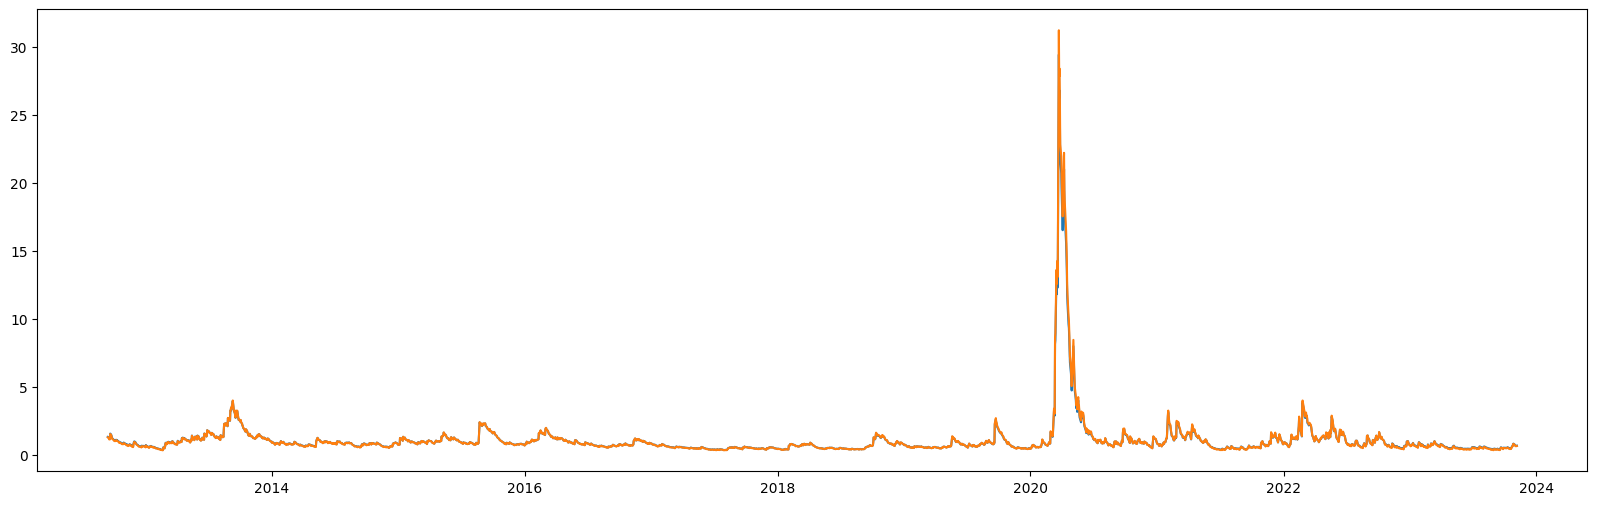

In [35]:

plt.figure(figsize=(20, 6))
plt.plot(result_df["5d_vol"])
plt.plot(result_df["h.1"])
plt.legend
plt.show()

In [25]:
df.head()

,Adj Close,log_returns
Date,,
2007-09-17,4494.649902,0.000000
2007-09-18,4546.200195,1.140398
2007-09-19,4732.350098,4.013017
2007-09-20,4747.549805,0.320673
2007-09-21,4837.549805,1.877970


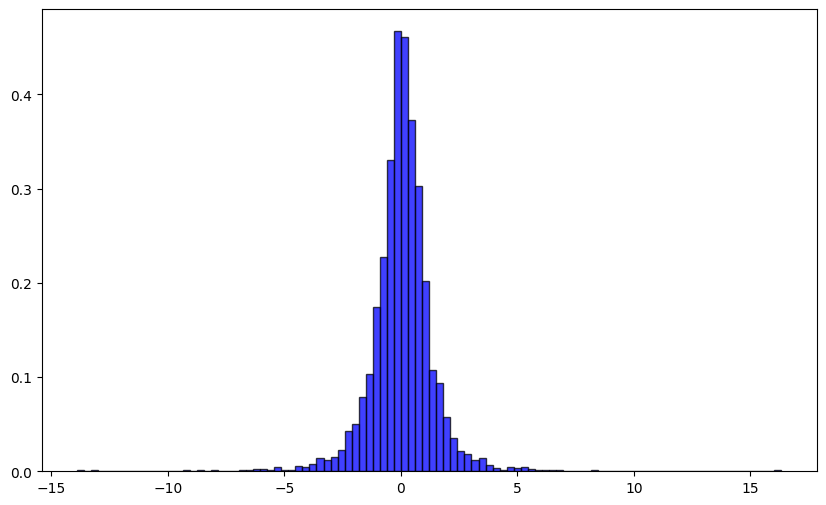

In [38]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["log_returns"], bins=100, density=True, alpha=0.75, color='b', edgecolor='black')
plt.show()

In [40]:
end_date = df.index[-1]
start_date = end_date - pd.DateOffset(years = 2)
returns = df.loc[start_date:end_date]["log_returns"]

# Calculate the first four moments of the return series
mean = np.mean(returns)
variance = np.var(returns)
skewness = skew(returns)
kurt = kurtosis(returns)

# Create a normal distribution object
distribution = norm(loc=mean, scale=variance)

# Define percentiles (e.g., from 1 to 99 with a step of 1)
percentiles = np.array([0.03, 5, 32, 68, 95, 99.7])

# Calculate the returns at each percentile using the percent-point function (ppf)
returns_at_percentiles = distribution.ppf(percentiles / 100)

# Divide the column into quantiles using custom bin edges
df['Quantiles'] = pd.cut(df['Column'], bins=returns_at_percentiles, labels=False, include_lowest=True)

0.03th percentile return: -2.8687
5.0th percentile return: -1.3666
32.0th percentile return: -0.3770
68.0th percentile return: 0.4093
95.0th percentile return: 1.3989
99.7th percentile return: 2.3261
